# Benchmarking `nvjpeg` 📊

In [ ]:
%run benchmark_nvjpeg_LoLa.py

# 📈 Data Visualization & Analysis

Now we will plot the collected data to understand the results. We will focus on:
1.  **Rate-Distortion:** How do quality metrics (like VMAF) change with file size?
2.  **Quality vs. File Size:** How does the `-quality` setting impact file size for different subsampling methods?
3.  **Encoding Performance:** Which Format method is fastest? How does resolution affect encoding time?
4.  **Decoding Performance:** How does resolution affect decoding time?

In [27]:
# --- Main Configuration ---
# Resolutions to test (Name: (Width, Height))
RESOLUTIONS = {
    '1280x720': (1280, 720),
    '1920x1080': (1920, 1080),
    '3840x2160': (3840, 2160),
}

RESOLUTION_TO_FILENAME = {
    '1280x720': 'frame_hd.rgb',
    '1920x1080': 'frame_fullhd.rgb',
    '3840x2160': 'frame_ultrahd.rgb',
}

# Parameters to benchmark
QUALITIES = range(10, 101, 1)
SUBSAMPLINGS = ['4:4:4', '4:2:2', '4:2:0']

SUBSAMPLING_TO_PARAM = {
    '4:4:4': '444',
    '4:2:2': '422',
    '4:2:0': '420'
}

In [28]:
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
df = pd.read_csv('results_nvjpeg+jpeggpu_complete.csv')
df.head()

,Resolution,Quality,Subsampling,Iterations,Avg Encode Time (s),Encoder Setup Time (s),Encoder Cleanup Time (s),Avg Decode Time (s),Decoder Setup Time (s),Decoder Cleanup Time (s),Compressed Size (KB),PSNR,SSIM,Encode CMD,Decode CMD
0,1280x720,10,4:4:4,10,0.000251,0.141738,0.000006,0.001558,0.000700,0.000000,47.241,24.940186,0.783426,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
1,1280x720,10,4:2:2,10,0.000167,0.114235,0.000005,0.001316,0.000688,0.000000,39.696,24.874296,0.782243,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
2,1280x720,10,4:2:0,10,0.000151,0.119442,0.000005,0.001374,0.000679,0.000000,36.314,24.795870,0.781879,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
3,1280x720,20,4:4:4,10,0.000207,0.115674,0.000007,0.001457,0.000687,0.000001,67.020,26.147650,0.853533,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
4,1280x720,20,4:2:2,10,0.000172,0.108538,0.000005,0.001308,0.000679,0.000000,58.633,26.071690,0.850630,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...


In [30]:
# Set plot style
sns.set_theme(style="whitegrid")

## Encoding Parameters vs. quality metrics

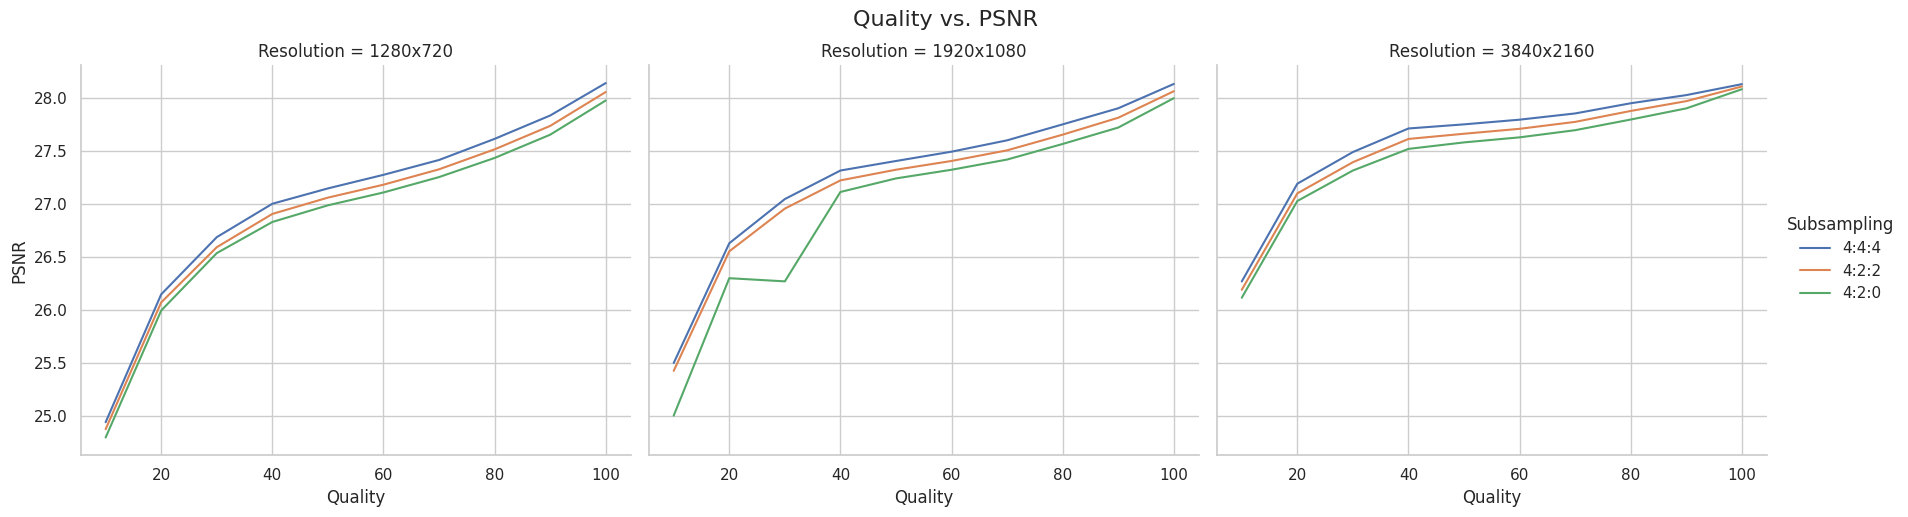

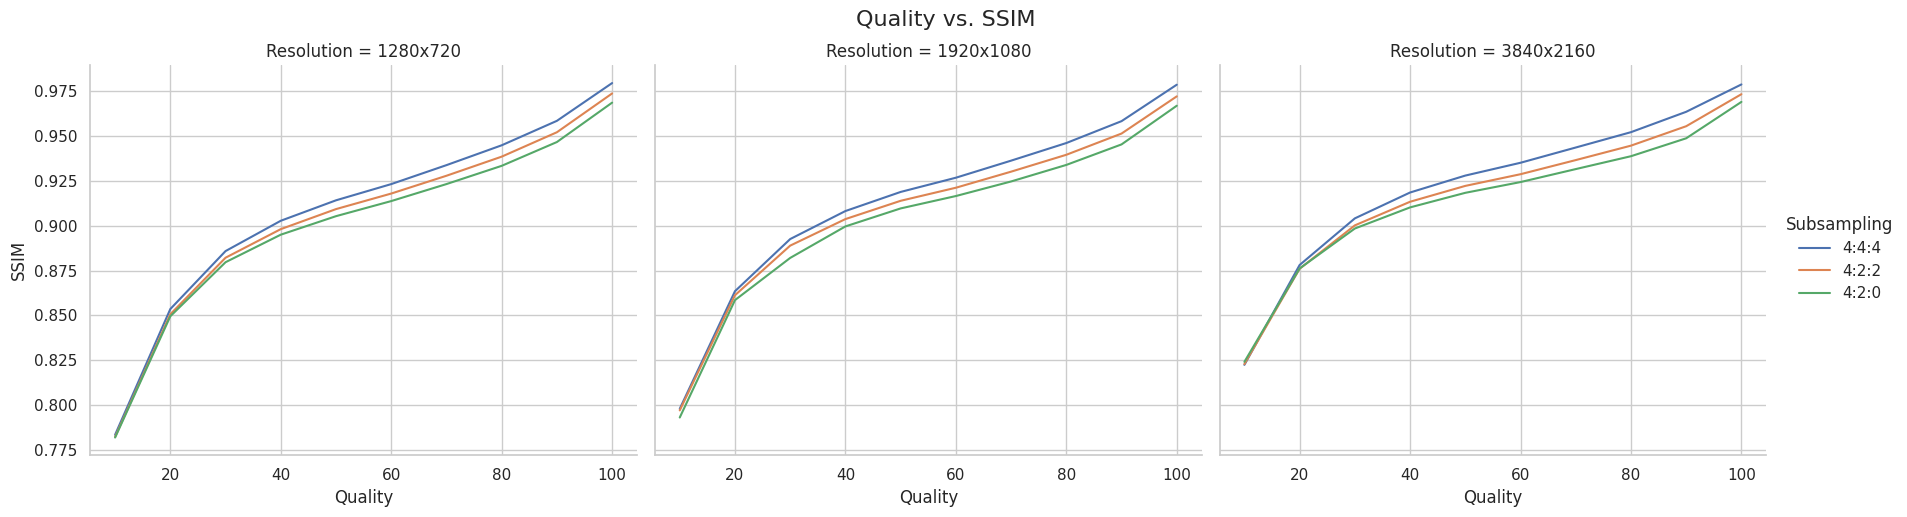

In [31]:
x = 'Quality'
y = 'PSNR'

g = sns.relplot(
    data=df,
    x=x,
    y=y,
    hue='Subsampling',
    col='Resolution',
    kind='line',
    height=5,
    aspect=1.2,
    col_order=RESOLUTIONS.keys(),
    facet_kws={'sharex': False}
)

g.figure.suptitle(f'{x} vs. {y}', y=1.03, fontsize=16)
g.set_axis_labels(x, y)
plt.show()

x = 'Quality'
y = 'SSIM'

g = sns.relplot(
    data=df,
    x=x,
    y=y,
    hue='Subsampling',
    col='Resolution',
    kind='line',
    height=5,
    aspect=1.2,
    col_order=RESOLUTIONS.keys(),
    facet_kws={'sharex': False}
)

g.figure.suptitle(f'{x} vs. {y}', y=1.03, fontsize=16)
g.set_axis_labels(x, y)
plt.show()

## Encoding Parameters vs. File Size


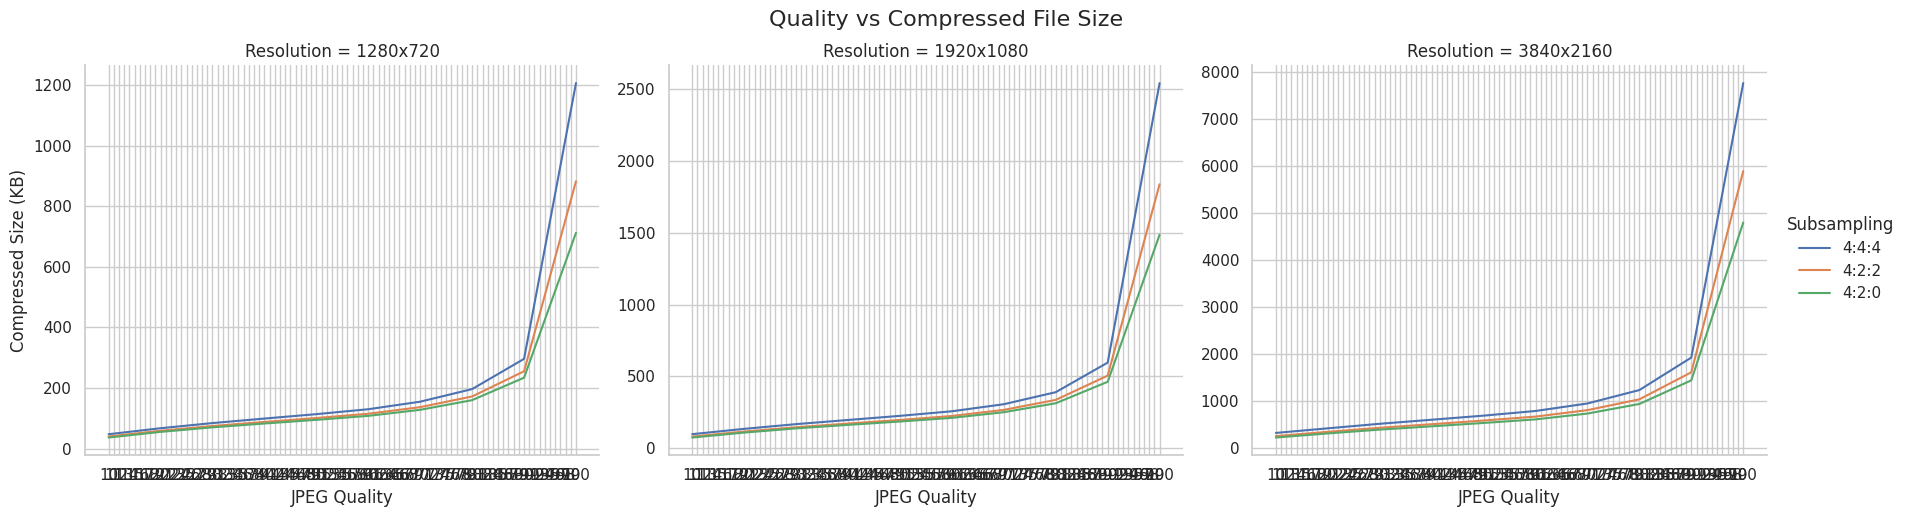

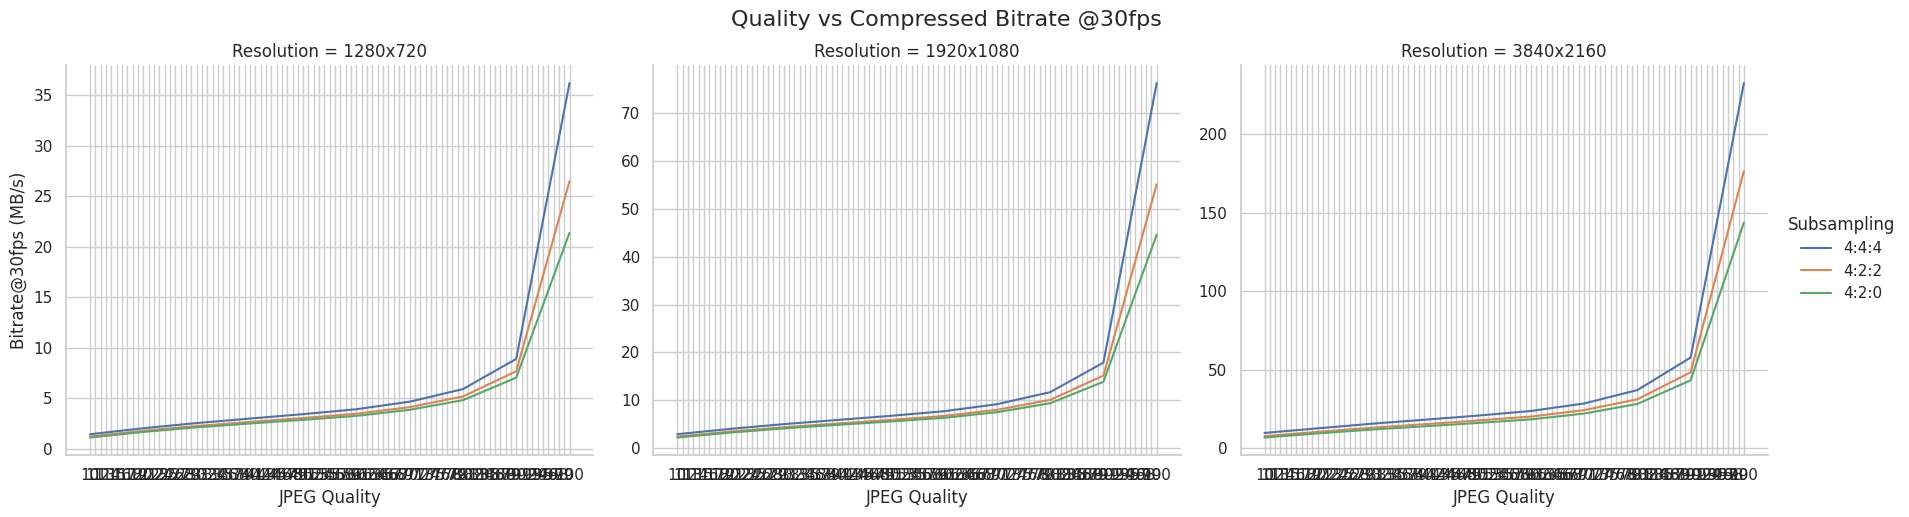

In [32]:
g = sns.relplot(
    data=df,
    x='Quality',
    y='Compressed Size (KB)',
    hue='Subsampling',
    col='Resolution',
    kind='line',
    height=5,
    aspect=1.2,
    col_order=RESOLUTIONS.keys(),
    facet_kws={'sharey': False}
)
g.figure.suptitle('Quality vs Compressed File Size', y=1.03, fontsize=16)
g.set_axis_labels('JPEG Quality', 'Compressed Size (KB)')
g.set(xticks=QUALITIES)
plt.show()

fps = 30
g = sns.relplot(
    data=df,
    x='Quality',
    y=df['Compressed Size (KB)'] * fps / 1000,
    hue='Subsampling',
    col='Resolution',
    kind='line',
    height=5,
    aspect=1.2,
    col_order=RESOLUTIONS.keys(),
    facet_kws={'sharey': False},
)
g.figure.suptitle(f'Quality vs Compressed Bitrate @{fps}fps', y=1.03, fontsize=16)
g.set_axis_labels('JPEG Quality', f'Bitrate@{fps}fps (MB/s)')
g.set(xticks=QUALITIES)
plt.show()

We can observe an explosion in file size from quality 95 onwards, and a sharp increase from quality 90 onwards.

## Encoding Parameters vs. Performance

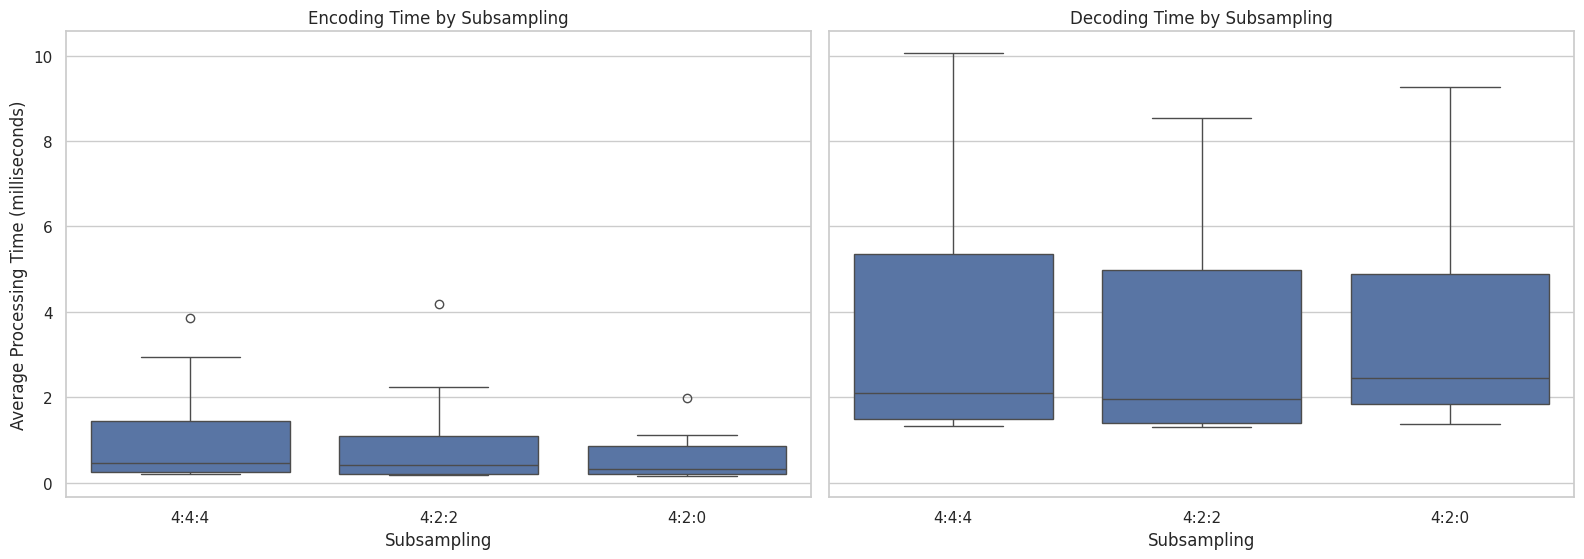

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
# Plot #1: Encoding time by Subsampling method
sns.boxplot(
    data=df,
    x='Subsampling',
    y=df['Avg Encode Time (s)'] * 1000,
    order=SUBSAMPLINGS,
    ax=ax[0]
)
ax[0].set_title('Encoding Time by Subsampling')
ax[0].set_ylabel('Average Processing Time (milliseconds)')

# Plot #2: Decoding time by Subsampling method
sns.boxplot(
    data=df,
    x='Subsampling',
    y=df['Avg Decode Time (s)'] * 1000,
    order=SUBSAMPLINGS,
    ax=ax[1]
)
ax[1].set_title('Decoding Time by Subsampling')
plt.tight_layout(rect=[0.0, 0.0, 1.0, 0.96])
plt.show()

In [34]:
df = df[df['Subsampling'] == '4:2:0']

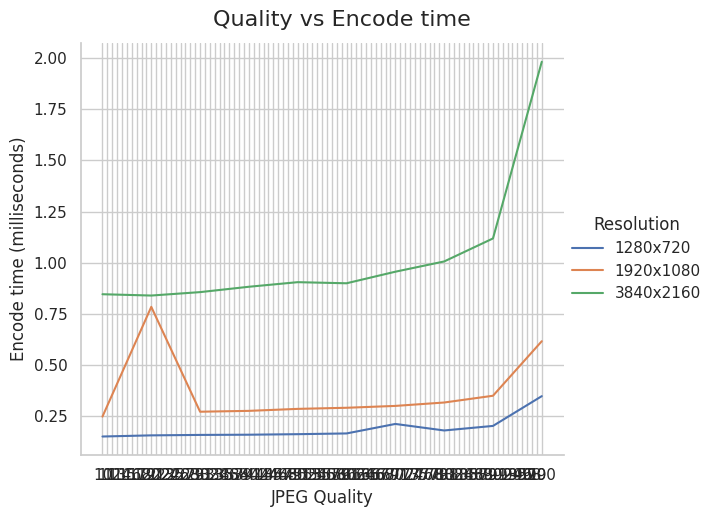

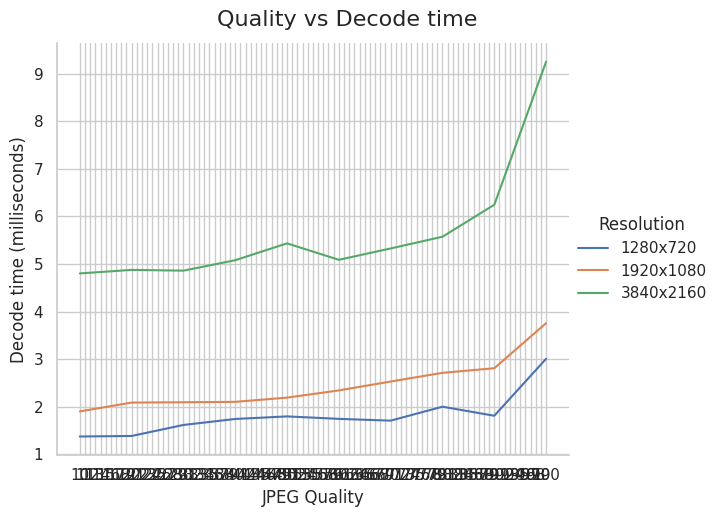

In [35]:
g = sns.relplot(
    data=df,
    x='Quality',
    y=df['Avg Encode Time (s)'] * 1000,
    hue='Resolution',
    kind='line',
    height=5,
    aspect=1.2,
    facet_kws={'sharey': False}
)
g.figure.suptitle('Quality vs Encode time', y=1.03, fontsize=16)
g.set_axis_labels('JPEG Quality', 'Encode time (milliseconds)')
g.set(xticks=QUALITIES)
plt.show()

g = sns.relplot(
    data=df,
    x='Quality',
    y=df['Avg Decode Time (s)'] * 1000,
    hue='Resolution',
    kind='line',
    height=5,
    aspect=1.2,
    facet_kws={'sharey': False}
)
g.figure.suptitle('Quality vs Decode time', y=1.03, fontsize=16)
g.set_axis_labels('JPEG Quality', 'Decode time (milliseconds)')
g.set(xticks=QUALITIES)
df = df[df['Avg Encode Time (s)'] * 1000 + df['Avg Decode Time (s)'] * 1000 <= 2 * 2]
plt.show()

In [36]:
df = df[df['Avg Encode Time (s)'] * 1000 + df['Avg Decode Time (s)'] * 1000 <= 2 * 2]
#df = df[df['Avg Encode Time (s)'] * 1000 <= 2]
#df = df[df['Avg Decode Time (s)'] * 1000 <= 2]
df.sort_values(by='SSIM', ascending=False).head(5)

,Resolution,Quality,Subsampling,Iterations,Avg Encode Time (s),Encoder Setup Time (s),Encoder Cleanup Time (s),Avg Decode Time (s),Decoder Setup Time (s),Decoder Cleanup Time (s),Compressed Size (KB),PSNR,SSIM,Encode CMD,Decode CMD
29,1280x720,100,4:2:0,10,0.000348,0.112768,0.000006,0.003007,0.000688,0.000000,712.212,27.978127,0.968623,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
26,1280x720,90,4:2:0,10,0.000203,0.111568,0.000005,0.001810,0.000689,0.000000,233.879,27.654984,0.946656,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
56,1920x1080,90,4:2:0,10,0.000350,0.113300,0.000007,0.002809,0.000847,0.000001,461.471,27.722435,0.945337,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
53,1920x1080,80,4:2:0,10,0.000317,0.113656,0.000007,0.002712,0.000694,0.000000,311.960,27.567432,0.933894,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
23,1280x720,80,4:2:0,10,0.000180,0.113724,0.000006,0.002001,0.000697,0.000000,159.676,27.435431,0.933384,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...


In [37]:
df = df[df['Avg Encode Time (s)'] * 1000 + df['Avg Decode Time (s)'] * 1000 <= 1.5 * 2]
#df = df[df['Avg Encode Time (s)'] * 1000 <= 1.5]
#df = df[df['Avg Decode Time (s)'] * 1000 <= 1.5]
df.sort_values(by='SSIM', ascending=False).head(5)

,Resolution,Quality,Subsampling,Iterations,Avg Encode Time (s),Encoder Setup Time (s),Encoder Cleanup Time (s),Avg Decode Time (s),Decoder Setup Time (s),Decoder Cleanup Time (s),Compressed Size (KB),PSNR,SSIM,Encode CMD,Decode CMD
26,1280x720,90,4:2:0,10,0.000203,0.111568,0.000005,0.001810,0.000689,0.000000,233.879,27.654984,0.946656,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
23,1280x720,80,4:2:0,10,0.000180,0.113724,0.000006,0.002001,0.000697,0.000000,159.676,27.435431,0.933384,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
50,1920x1080,70,4:2:0,10,0.000300,0.116620,0.000007,0.002530,0.000687,0.000001,249.489,27.420284,0.924667,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
20,1280x720,70,4:2:0,10,0.000212,0.121857,0.000006,0.001707,0.000710,0.000000,127.818,27.254725,0.923213,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
47,1920x1080,60,4:2:0,10,0.000291,0.112685,0.000007,0.002343,0.000693,0.000000,210.189,27.323952,0.916542,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...


In [38]:
df = df[df['Avg Encode Time (s)'] * 1000 + df['Avg Decode Time (s)'] * 1000 <= 1 * 2]
#df = df[df['Avg Encode Time (s)'] * 1000 <= 1]
#df = df[df['Avg Decode Time (s)'] * 1000 <= 1]
df.sort_values(by='SSIM', ascending=False).head(5)

,Resolution,Quality,Subsampling,Iterations,Avg Encode Time (s),Encoder Setup Time (s),Encoder Cleanup Time (s),Avg Decode Time (s),Decoder Setup Time (s),Decoder Cleanup Time (s),Compressed Size (KB),PSNR,SSIM,Encode CMD,Decode CMD
20,1280x720,70,4:2:0,10,0.000212,0.121857,0.000006,0.001707,0.000710,0.000000,127.818,27.254725,0.923213,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
17,1280x720,60,4:2:0,10,0.000166,0.112138,0.000006,0.001745,0.000686,0.000000,107.829,27.109501,0.913729,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
14,1280x720,50,4:2:0,10,0.000162,0.112658,0.000005,0.001797,0.000689,0.000000,94.690,26.988144,0.905312,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
11,1280x720,40,4:2:0,10,0.000160,0.114322,0.000005,0.001742,0.000845,0.000001,82.585,26.830982,0.894994,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
8,1280x720,30,4:2:0,10,0.000159,0.111791,0.000005,0.001617,0.000830,0.000000,69.973,26.536762,0.879645,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...


In [40]:
df = df[df['Avg Encode Time (s)'] * 1000 + df['Avg Decode Time (s)'] * 1000 <= 0.5 * 2]##
#df = df[df['Avg Encode Time (s)'] * 1000 <= 0.5]
#df = df[df['Avg Decode Time (s)'] * 1000 <= 0.5]
df.sort_values(by='SSIM', ascending=False).head(5)

,Resolution,Quality,Subsampling,Iterations,Avg Encode Time (s),Encoder Setup Time (s),Encoder Cleanup Time (s),Avg Decode Time (s),Decoder Setup Time (s),Decoder Cleanup Time (s),Compressed Size (KB),PSNR,SSIM,Encode CMD,Decode CMD
